In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import glob
import re
import math
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from matplotlib.font_manager import FontProperties
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


In [6]:
# from the description of the data set at
# kaggle.com/beyjin/movies-1990-to-2017/home#Movie_Writer.csv
# we know that we have multiple csv files with information on
# roughly 200000 movies let's find out what information this is
# and try to answer some questions with the data set 

In [3]:
# show the folder structure
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'conversion_rates.db',
 'data',
 'fixerio_update',
 'notes',
 'predict_movie_rating.png',
 'rates.csv',
 'README.md',
 'Task_Data_Analyst.ipynb',
 'Task_Data_Engineer.ipynb',
 'Task_DE_WebScraping.ipynb']

In [2]:
# check what date we have
os.listdir('data')

['Movie_Actors.csv',
 'Movie_AdditionalRating.csv',
 'Movie_Genres.csv',
 'Movie_Movies.csv',
 'Movie_Writer.csv']

In [8]:
# from the kaggle website we know that Movie_Movies.csv
# is the most important file; let's read it into a data frame
# using default values
df = pd.read_csv('data/Movie_Movies.csv')
df.head(5)

,Awards,Country,DVD,Director,Language,Plot,Poster,Production,Rated,Released,Runtime,Title,Type,Website,Year,imdbID,imdbRating,imdbVotes
0,NaN,USA,NaN,Rose Cummings,English,Rachel constantly hears her baby cry from the ...,NaN,NaN,NaN,26 Apr 2012,20 min,Baby's Breath,movie,NaN,2012,tt2268369,NaN,NaN
1,NaN,USA,NaN,James Byrne,NaN,The struggle against unfortunate circumstances...,NaN,NaN,NaN,NaN,9 min,Winter Trees,movie,NaN,2008,tt1560760,NaN,NaN
2,NaN,USA,NaN,Dimitri Buchowetzki,NaN,NaN,NaN,NaN,NaN,27 Mar 1926,50 min,The Crown of Lies,movie,NaN,1926,tt0016750,NaN,NaN
3,NaN,USA,NaN,Julia Hechler,English,"A Gift introduces Samuel Green, Washington Sta...",NaN,NaN,NaN,27 May 2013,2 min,A Gift,movie,NaN,2013,tt3405286,NaN,NaN
4,NaN,Sri Lanka,NaN,Udara Siriruwan,Sinhalese,NaN,NaN,NaN,NaN,20 Mar 2014,23 min,Journey,movie,NaN,2014,tt3816698,NaN,NaN


In [9]:
# this has worked well; we come to the warning later
# how big is that data set?
# which variables do we have per movie?
s = df.shape
print ('The data has {:d} rows (i.e. movies) and {:d} columns (i.e. infos on each movie) \n\n'.format(s[0],s[1]))

print ('Per movie we have these infos:\n')
for v in list(df.columns):
    print(v)

The data has 178687 rows (i.e. movies) and 18 columns (i.e. infos on each movie) 


Per movie we have these infos:

Awards
Country
DVD
Director
Language
Plot
Poster
Production
Rated
Released
Runtime
Title
Type
Website
Year
imdbID
imdbRating
imdbVotes


In [10]:
# from the kaggle data set info site we have learned that
# 'NOT_GIVEN' is a missing; let's replace that and 'NaN'
# with np.nan
df.replace(['NOT_GIVEN','NaN'],[np.nan,np.nan],inplace=True)


In [11]:
# let's get a quick description of the data; as far as possible
# having not done any thorough data cleaning yet
# with NaN's removed
print(df.describe())

         imdbRating
count  62073.000000
mean       6.416236
std        1.360472
min        1.000000
25%        5.600000
50%        6.500000
75%        7.300000
max       10.000000


In [12]:
# there is only one numerical variable; the rest is probably string objects
df.dtypes

Awards         object
Country        object
DVD            object
Director       object
Language       object
Plot           object
Poster         object
Production     object
Rated          object
Released       object
Runtime        object
Title          object
Type           object
Website        object
Year           object
imdbID         object
imdbRating    float64
imdbVotes      object
dtype: object

In [13]:
# let's check the warning about column 14
# pandas said the objects there are of mixed data type
# which one is it?
print(df[df.columns[14]].head(20))

0     2012
1     2008
2     1926
3     2013
4     2014
5     2014
6     2009
7     1915
8     1966
9     2005
10    2014
11    2016
12    2017
13    2002
14    2015
15    2014
16    2004
17    2004
18    2011
19    2008
Name: Year, dtype: object


In [14]:
# Seems like integer-like.
# Year should be an easy variable to simply
# convert into a datetime object
# it works for the first 20 but when we try it for all
# then there is an error raised
print(pd.to_datetime(df[df.columns[14]].head(20),format='%Y'))

0    2012-01-01
1    2008-01-01
2    1926-01-01
3    2013-01-01
4    2014-01-01
5    2014-01-01
6    2009-01-01
7    1915-01-01
8    1966-01-01
9    2005-01-01
10   2014-01-01
11   2016-01-01
12   2017-01-01
13   2002-01-01
14   2015-01-01
15   2014-01-01
16   2004-01-01
17   2004-01-01
18   2011-01-01
19   2008-01-01
Name: Year, dtype: datetime64[ns]


In [15]:
# let's look at the error
#pd.to_datetime(df[df.columns[14]],format='%Y')

In [16]:
# we get a TypeError; to_datetime expects strings
# so pandas made some years into strings
# some of them into float
# let's make them all to integer and then to string
# to get the format we need;
# but check closely if it works
def int_str(x):
    return(str(int(x)))

def cast_analysis(x,cast_func):
    """function that tries to cast via
    cast_func all elements in x; collects
    uncastables and returns those
    and returns the vector x cast with np.nan
    where not castable"""
    problem_entries = []
    x_cast = []
    for v in enumerate(x):
        try:
            x_cast.append(cast_func(v[1]))
        except:
            x_cast.append(np.nan)
            problem_entries.append(v)
    
    return((problem_entries,x_cast))

# let's run the cast and check which ones do not work
problem_entries, x_cast = cast_analysis(df[df.columns[14]],cast_func=int_str)


In [17]:
# now let's check which ones we cannot cast
print(problem_entries[0:10])

[(123293, nan), (174976, '2003–2005'), (175429, '2007–2011'), (176137, '2010–2013'), (176358, '2012–2016')]


In [18]:
# we have year ranges given; maybe those are TV series
for p in problem_entries:
    print(df.iloc[p[0],:])
    print('\n')

Awards        NaN
Country       NaN
DVD           NaN
Director      NaN
Language      NaN
Plot          NaN
Poster        NaN
Production    NaN
Rated         NaN
Released      NaN
Runtime       NaN
Title         NaN
Type          NaN
Website       NaN
Year          NaN
imdbID        NaN
imdbRating    NaN
imdbVotes     NaN
Name: 123293, dtype: object


Awards                                                   1 win.
Country                                                      UK
DVD                                                         NaN
Director                                                    NaN
Language                                                English
Plot          Animated sketches take a darkly satirical swip...
Poster        https://images-na.ssl-images-amazon.com/images...
Production                                                  NaN
Rated                                                       NaN
Released                                            09 Feb 2003
Runtim

In [19]:
# indeed they are series
# but we also see that we have a release date, so we will
# have a variable "year_final_release" which is in the case
# of a movie the release year and in case of the series
# the year of the final season
# but firstly this value array is handy for the next step
problem_entries_v = [x[1] for x in problem_entries]
print(problem_entries_v)

[nan, '2003–2005', '2007–2011', '2010–2013', '2012–2016']


In [20]:
df[df.columns[14]].replace(problem_entries_v,
                          [np.nan, '2005', '2011', '2013', '2016'],
                           inplace = True)

In [21]:
# now we run the cast analysis again and only nan is left
problem_entries, x_cast = cast_analysis(df[df.columns[14]],cast_func=int_str)
print(problem_entries)

[(123293, nan)]


In [22]:
# we create the new variable, as announced
df['year_final_release'] = x_cast

In [23]:
# let's try if we can now cast all years to date_time objects
problem_entries, x_cast = cast_analysis(df['year_final_release'],cast_func=pd.to_datetime)
print(problem_entries)

[]


In [24]:
# yes, we have no more cast problems and we know what the variable means
df['year_final_release'] = x_cast
print(df['year_final_release'].head(20))
print(df['year_final_release'].tail(20))

0    2012-01-01
1    2008-01-01
2    1926-01-01
3    2013-01-01
4    2014-01-01
5    2014-01-01
6    2009-01-01
7    1915-01-01
8    1966-01-01
9    2005-01-01
10   2014-01-01
11   2016-01-01
12   2017-01-01
13   2002-01-01
14   2015-01-01
15   2014-01-01
16   2004-01-01
17   2004-01-01
18   2011-01-01
19   2008-01-01
Name: year_final_release, dtype: datetime64[ns]
178667   1999-01-01
178668   1999-01-01
178669   1999-01-01
178670   1999-01-01
178671   1999-01-01
178672   1999-01-01
178673   1999-01-01
178674   1999-01-01
178675   1999-01-01
178676   1999-01-01
178677   1999-01-01
178678   1999-01-01
178679   1999-01-01
178680   1999-01-01
178681   1999-01-01
178682   1999-01-01
178683   1999-01-01
178684   1999-01-01
178685   1999-01-01
178686   1999-01-01
Name: year_final_release, dtype: datetime64[ns]


In [25]:
# however, now we see in the tail a lot of "1999" dates
# is it ordered, or have many years been cast wrongly?
# let's check the original variable again
print(df[df.columns[14]].tail(40))


178647    1999
178648    1999
178649    1999
178650    1999
178651    1999
178652    1999
178653    1999
178654    1999
178655    1999
178656    1999
178657    1999
178658    1999
178659    1999
178660    1999
178661    1999
178662    1999
178663    1999
178664    1999
178665    1999
178666    1999
178667    1999
178668    1999
178669    1999
178670    1999
178671    1999
178672    1999
178673    1999
178674    1999
178675    1999
178676    1999
178677    1999
178678    1999
178679    1999
178680    1999
178681    1999
178682    1999
178683    1999
178684    1999
178685    1999
178686    1999
Name: Year, dtype: object


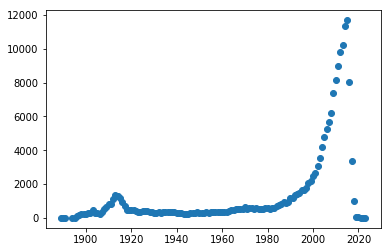

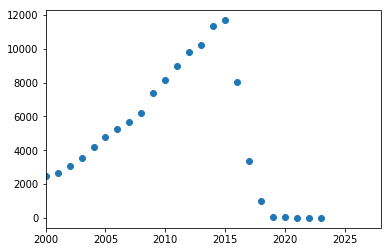

In [26]:
# It is not; how many movies were produced per year seems to be 
# quite randomly distributed
# but there should be a trend: over the past 50 or so years
# more and more movies should have been produced
X = pd.Series([d.year for d in df['year_final_release']]).value_counts()
x = np.array(X.keys())
y = X[x]

plt.scatter(x,y)
plt.show()

# it is an exponential increase as can be expected
# the drop in the end may just be a problem of data collection
# the fresh data is not complete yet; we also see movies
# in the future (beyond 2019); maybe those are announcements of releases
plt.scatter(x,y)
plt.xlim(2000,2028)
plt.show()

In [27]:
# let's already fix imdbVotes too, because we need it later:
problem_entries, x_cast = cast_analysis(df.imdbVotes,cast_func=int)
print(problem_entries[0:10])

[(0, nan), (1, nan), (2, nan), (3, nan), (4, nan), (5, nan), (6, nan), (7, nan), (8, nan), (10, nan)]


In [28]:
# looking at the problems: we have comma-separated
# numbers e.g. 100,000
df.imdbVotes = df.imdbVotes.str.replace(',','')
def get_int(x):
    if pd.isna(x):
        return(np.nan)
    else:
        return(int(x))
    
problem_entries, x_cast = cast_analysis(df.imdbVotes,cast_func=get_int)
print(problem_entries)

[]


In [29]:
# we have successfully cast the imdbVotes variable to numeric
df.imdbVotes = x_cast

In [30]:
# and so we will continue
# usually we would have to check all variables and make sure they are in
# a completely machine-readable format
# here let's look firstly at two more variables
#[.....................................Country]

In [31]:
# Let's turn to the next task
# "As a user I´d like to know how many movies the Top10 directors in the data set produced. 
# Prepare a list of the top 10 Directors with the following information"
# Every line is one movie so we need to just look at the Director column
print(df.Director[0:20])


0           Rose Cummings
1             James Byrne
2     Dimitri Buchowetzki
3           Julia Hechler
4         Udara Siriruwan
5        Malini Schueller
6             Philip Shaw
7           Ben F. Wilson
8        Yeong-cheol Choi
9                     NaN
10           David Morris
11          Romeo Candido
12                    NaN
13                    NaN
14           David Gunson
15              Matt Hish
16            Meiert Avis
17           Paul Obazele
18             Fendou Liu
19        Patrick Devaney
Name: Director, dtype: object


In [32]:
# sometimes there is an addition after director's name
# "(co-director)"; we will get rid of this
# alternative: only take into account first director...
# depends on the case
df.Director = df.Director.str.replace('(co-director)','',regex=False)

In [33]:
# The problem is that one movie may have multiple directors
# split by a ',' or something else
comma_directors = df.Director[[str(v).find(',') != -1 for v in df.Director]]
print(comma_directors[0:10])
print('\n')

semicolon_directors = df.Director[[str(v).find(';') != -1 for v in df.Director]]
print(semicolon_directors[0:10])

21          Terry L. Noss, Richard Rich
34      Nicholas Kohut, Lauren Mountain
44          Darren Powell, Garret Smith
58       Leslie Small, David E. Talbert
69            Benjamin Kim, Jess Koster
89               Ger Duffy, Daire Glynn
95     Clara Kuperberg, Julia Kuperberg
108           Jonathan Ramey, Jeff Ryan
137              Yoni Brook, Musa Syeed
149        Noel Buckner, Rob Whittlesey
Name: Director, dtype: object


47324    Heckle, Dewey &#39;Pigmeat&#39; Markham
Name: Director, dtype: object


In [34]:
# so we have a couple "," cases
# and also one ";" case
print(df.iloc[47324,])

Awards                                                    NaN
Country                                                   USA
DVD                                                       NaN
Director              Heckle, Dewey &#39;Pigmeat&#39; Markham
Language                                              English
Plot                                                      NaN
Poster                                                    NaN
Production                                                NaN
Rated                                                APPROVED
Released                                          27 Aug 1940
Runtime                                                25 min
Title                                    Mr. Smith Goes Ghost
Type                                                    movie
Website                                                   NaN
Year                                                     1940
imdbID                                              tt0234276
imdbRati

In [35]:
# check the directors online and this is a unicode error (?!)
df.Director.replace("Heckle, Dewey &#39;Pigmeat&#39; Markham","Heckle, Dewey 'Pigmeat' Markham",inplace=True)
print(df.Director.iloc[47324])

Heckle, Dewey 'Pigmeat' Markham


In [36]:
# now we have only "," cases left
df['DirectorArray'] = df.Director.str.split(',')

In [37]:
all_dirs = pd.Series(np.hstack(df['DirectorArray']).ravel())

def nan_from_string(x):
    if x == 'nan':
        return (np.nan)
    else:
        return(x)

all_dirs = all_dirs.apply(nan_from_string)

In [38]:
freq_dirs = pd.Series(all_dirs).value_counts()

In [129]:
df_top10 = pd.DataFrame({'Director': freq_dirs.iloc[0:10].index,
                         'NumberOfMovies': freq_dirs.iloc[0:10].values})
df_top10

                              Director  NumberOfMovies
0                           Jim Powers             156
1                       Dave Fleischer             109
2                        D.W. Griffith             103
3                      Lewin Fitzhamon              95
4                          Al Christie              90
5                       Georges Méliès              87
6  Gilbert M. 'Broncho Billy' Anderson              85
7                           Kevin Dunn              85
8                            Quasarman              84
9                          Nica Noelle              78


In [39]:
# why there are a bunch of directors here that one does not know
# remains to be google'd (e.g.: Nica Noelle)
# Or try looking at the movies by Jim Powers:
# df.loc[df.Director == 'Jim Powers']
# but we leave this for now...

In [40]:
# Free Data Mining: what else do we want to find out?
# from the website:
#'Do the actors, writer, director have an impact on the imdb scoring?'
# Let's start simple and try to check if director has an impact on rating
# get all Directors and imdbRatings and drop NA's
# TAKE OUT: also get the number of movies per director (that have numbers)
dfdr = df[['Director','imdbRating','imdbVotes']].dropna(axis=0)
dct = dfdr.Director.value_counts()
dct = pd.DataFrame({'Director':dct.index,'n_movies': dct})
dfdr = dfdr.merge(dct,on='Director',how='outer')
print(dfdr.iloc[1:20,])

                       Director  imdbRating  imdbVotes  n_movies
1                   Meiert Avis         6.3       11.0         4
2                   Meiert Avis         8.5       20.0         4
3                   Meiert Avis         5.7     1648.0         4
4                   Meiert Avis         4.2     2647.0         4
5                    Fendou Liu         5.5       43.0         1
6   Terry L. Noss, Richard Rich         5.0      813.0         1
7                   Joseph Kane         7.6       16.0        22
8                   Joseph Kane         6.4      187.0        22
9                   Joseph Kane         6.2       27.0        22
10                  Joseph Kane         4.7       84.0        22
11                  Joseph Kane         6.1      290.0        22
12                  Joseph Kane         6.0      147.0        22
13                  Joseph Kane         6.1       53.0        22
14                  Joseph Kane         6.0       87.0        22
15                  Josep

In [41]:
# This question needs to be posed more precisely since
# we have a lot of directors, and we cannot simply dummy-code them,
# because this would lead to many additional one-hot regressors
# and directors may have just one movie;
# So let's imagine: A film studio boss wants to know how 
# well the mean imdbrating of any director predicts the rating of a new movie,
# that he or she wants to find a director for:
# Director will be operationalized by their mean
# rating; and hence we would like to know, if -on average-
# the mean rating of a director is a good predictor of their 
# performance; if all directors had all their movie ratings
# equal their mean rating, then their mean rating
# gives perfect information on movie ratings; however,
# if there is a lot 
# of variance per director across his/her movies in ratings
# then this speaks to low predictiveness of the director's 
# mean rating
# TAKEOUT:
# additional predictors can be number of votes, year, ...
# interaction-terms; hence:
# Dependent variable: rating score of movie
# Independent variable: director's mean movie score, number of votes, 
# interaction mean movie*score_number_of_votes, year

# Attention: the data_set is large: we need to work with sub samples
# Attention: we need to exclude all directors that have less than 2 
# rated movies, because only then the representativeness of mean can
# be evaluated
dfdr = dfdr.loc[dfdr.n_movies>1,]
print(dfdr.iloc[0:20])

       Director  imdbRating  imdbVotes  n_movies
1   Meiert Avis         6.3       11.0         4
2   Meiert Avis         8.5       20.0         4
3   Meiert Avis         5.7     1648.0         4
4   Meiert Avis         4.2     2647.0         4
7   Joseph Kane         7.6       16.0        22
8   Joseph Kane         6.4      187.0        22
9   Joseph Kane         6.2       27.0        22
10  Joseph Kane         4.7       84.0        22
11  Joseph Kane         6.1      290.0        22
12  Joseph Kane         6.0      147.0        22
13  Joseph Kane         6.1       53.0        22
14  Joseph Kane         6.0       87.0        22
15  Joseph Kane         6.4       42.0        22
16  Joseph Kane         6.3       52.0        22
17  Joseph Kane         5.6      121.0        22
18  Joseph Kane         7.0       41.0        22
19  Joseph Kane         6.4       58.0        22
20  Joseph Kane         6.2      103.0        22
21  Joseph Kane         6.3      117.0        22
22  Joseph Kane     

In [42]:
# get the mean director's rating
# Note: multiple directors (name1, name2) will be left as is, it is then
# the pairing of directors that gets the mean rating
# note also the imdbRating is already a weighted average
# depending on the number of votes; the formula is secret but used to
# be public: https://en.wikipedia.org/wiki/IMDb
# so we take the given imdbratings as already adjusted for number of votes
# but we still will extract it for additional analysis
def director_rating(rdf):
    n_movies = np.array(rdf.n_movies)[0]
    mean_rating = np.dot(rdf.imdbRating,rdf.imdbVotes)/np.sum(rdf.imdbVotes)
    return((mean_rating,n_movies))

# get a subsample of directors (and their movies)
directors_sample = pd.Series(dfdr.Director.unique()).sample(n=4000, replace=False, random_state=100)
#print(directors_sample)
#print(dfdr.Director.isin(directors_sample))
dfdrs = dfdr.loc[dfdr.Director.isin(directors_sample),]

   
# sort the sample by number of movies 
dfdrs.sort_values(by=['Director']).iloc[0:10]

,Director,imdbRating,imdbVotes,n_movies
2789,A. Edward Sutherland,5.8,12.0,12
2784,A. Edward Sutherland,6.1,328.0,12
2783,A. Edward Sutherland,6.0,120.0,12
2782,A. Edward Sutherland,7.1,73.0,12
2787,A. Edward Sutherland,6.5,128.0,12
2788,A. Edward Sutherland,5.8,142.0,12
2785,A. Edward Sutherland,5.9,158.0,12
2790,A. Edward Sutherland,6.1,36.0,12
2786,A. Edward Sutherland,7.2,146.0,12
2781,A. Edward Sutherland,7.2,1014.0,12


In [43]:
# a single director's data
print(directors_sample.iloc[0])

rdf = dfdrs.loc[dfdrs.Director == directors_sample.iloc[0],]
rdf

Walter Lantz


,Director,imdbRating,imdbVotes,n_movies
7910,Walter Lantz,5.1,11.0,15
7911,Walter Lantz,5.3,6.0,15
7912,Walter Lantz,6.5,14.0,15
7913,Walter Lantz,5.5,11.0,15
7914,Walter Lantz,3.8,6.0,15
7915,Walter Lantz,6.3,20.0,15
7916,Walter Lantz,6.5,25.0,15
7917,Walter Lantz,6.2,20.0,15
7918,Walter Lantz,6.4,72.0,15
7919,Walter Lantz,6.3,15.0,15


In [44]:
dirs_ratings = []
dirs_n_movies = []
len_dirs = len(directors_sample)
for i,d in enumerate(directors_sample):
    rdf = dfdrs.loc[dfdrs.Director == d,]
    res = director_rating(rdf)
    dirs_ratings.append(res[0])
    dirs_n_movies.append(res[1])
    print(i/len_dirs, end="\r")

In [45]:
# let's look at the result
dirs_ratings_df = pd.DataFrame({'Director': directors_sample, 'mean_rating_director': dirs_ratings})
dirs_ratings_df.tail(10)

,Director,mean_rating_director
5514,Carlo Rim,5.860976
2056,Walter Hugo Khouri,6.575610
222,Craven Moorehead,6.999187
2332,Alexandre Aja,6.238100
1553,Joel Lamangan,5.390714
2520,Jean Yarbrough,6.085778
5737,Eliseo Subiela,6.174104
6171,Cristobal Araus Lobos,5.325275
3368,William Webb,5.900000
1599,Fred M. Wilcox,7.183290


In [46]:
# now we merge it
dfdrs = dfdrs.merge(dirs_ratings_df,on='Director',how='outer')
dfdrs

,Director,imdbRating,imdbVotes,n_movies,mean_rating_director
0,Meiert Avis,6.3,11.0,4,4.796648
1,Meiert Avis,8.5,20.0,4,4.796648
2,Meiert Avis,5.7,1648.0,4,4.796648
3,Meiert Avis,4.2,2647.0,4,4.796648
4,Joseph Kane,7.6,16.0,22,6.180216
5,Joseph Kane,6.4,187.0,22,6.180216
6,Joseph Kane,6.2,27.0,22,6.180216
7,Joseph Kane,4.7,84.0,22,6.180216
8,Joseph Kane,6.1,290.0,22,6.180216
9,Joseph Kane,6.0,147.0,22,6.180216


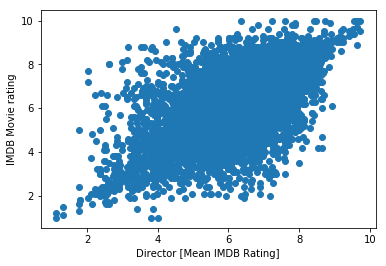

In [47]:
# let's plot it
X = dfdrs['mean_rating_director'].values.reshape(-1,1)
y = dfdrs['imdbRating']
plt.scatter(X,y)
plt.xlabel('Director [Mean IMDB Rating]')
plt.ylabel('IMDB Movie rating')
plt.show()

In [48]:
# we see quite some spread in the data and
# perhaps even heteroskedacity (uneqeual variance of error)
# across data (heavy cigar shape)

# now we model it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = LinearRegression().fit(X_train,y_train)

In [49]:
# let's predict the test_data
y_pred = model.predict(X_test)

In [50]:
# let's look at the model
b = model.coef_
i = model.intercept_

print('The model formula is:')
print('IMDB_Movie_Rating = {:.3f} + {:.3f}*mean_rating_director'.format(i,b[0]))

# how much variance can we explain in test data?
print('\n')
print('We can explain {:.0f} percent of variance in the test data.'.format(metrics.r2_score(y_test,y_pred)*100))

The model formula is:
IMDB_Movie_Rating = 1.487 + 0.759*mean_rating_director


We can explain 41 percent of variance in the test data.


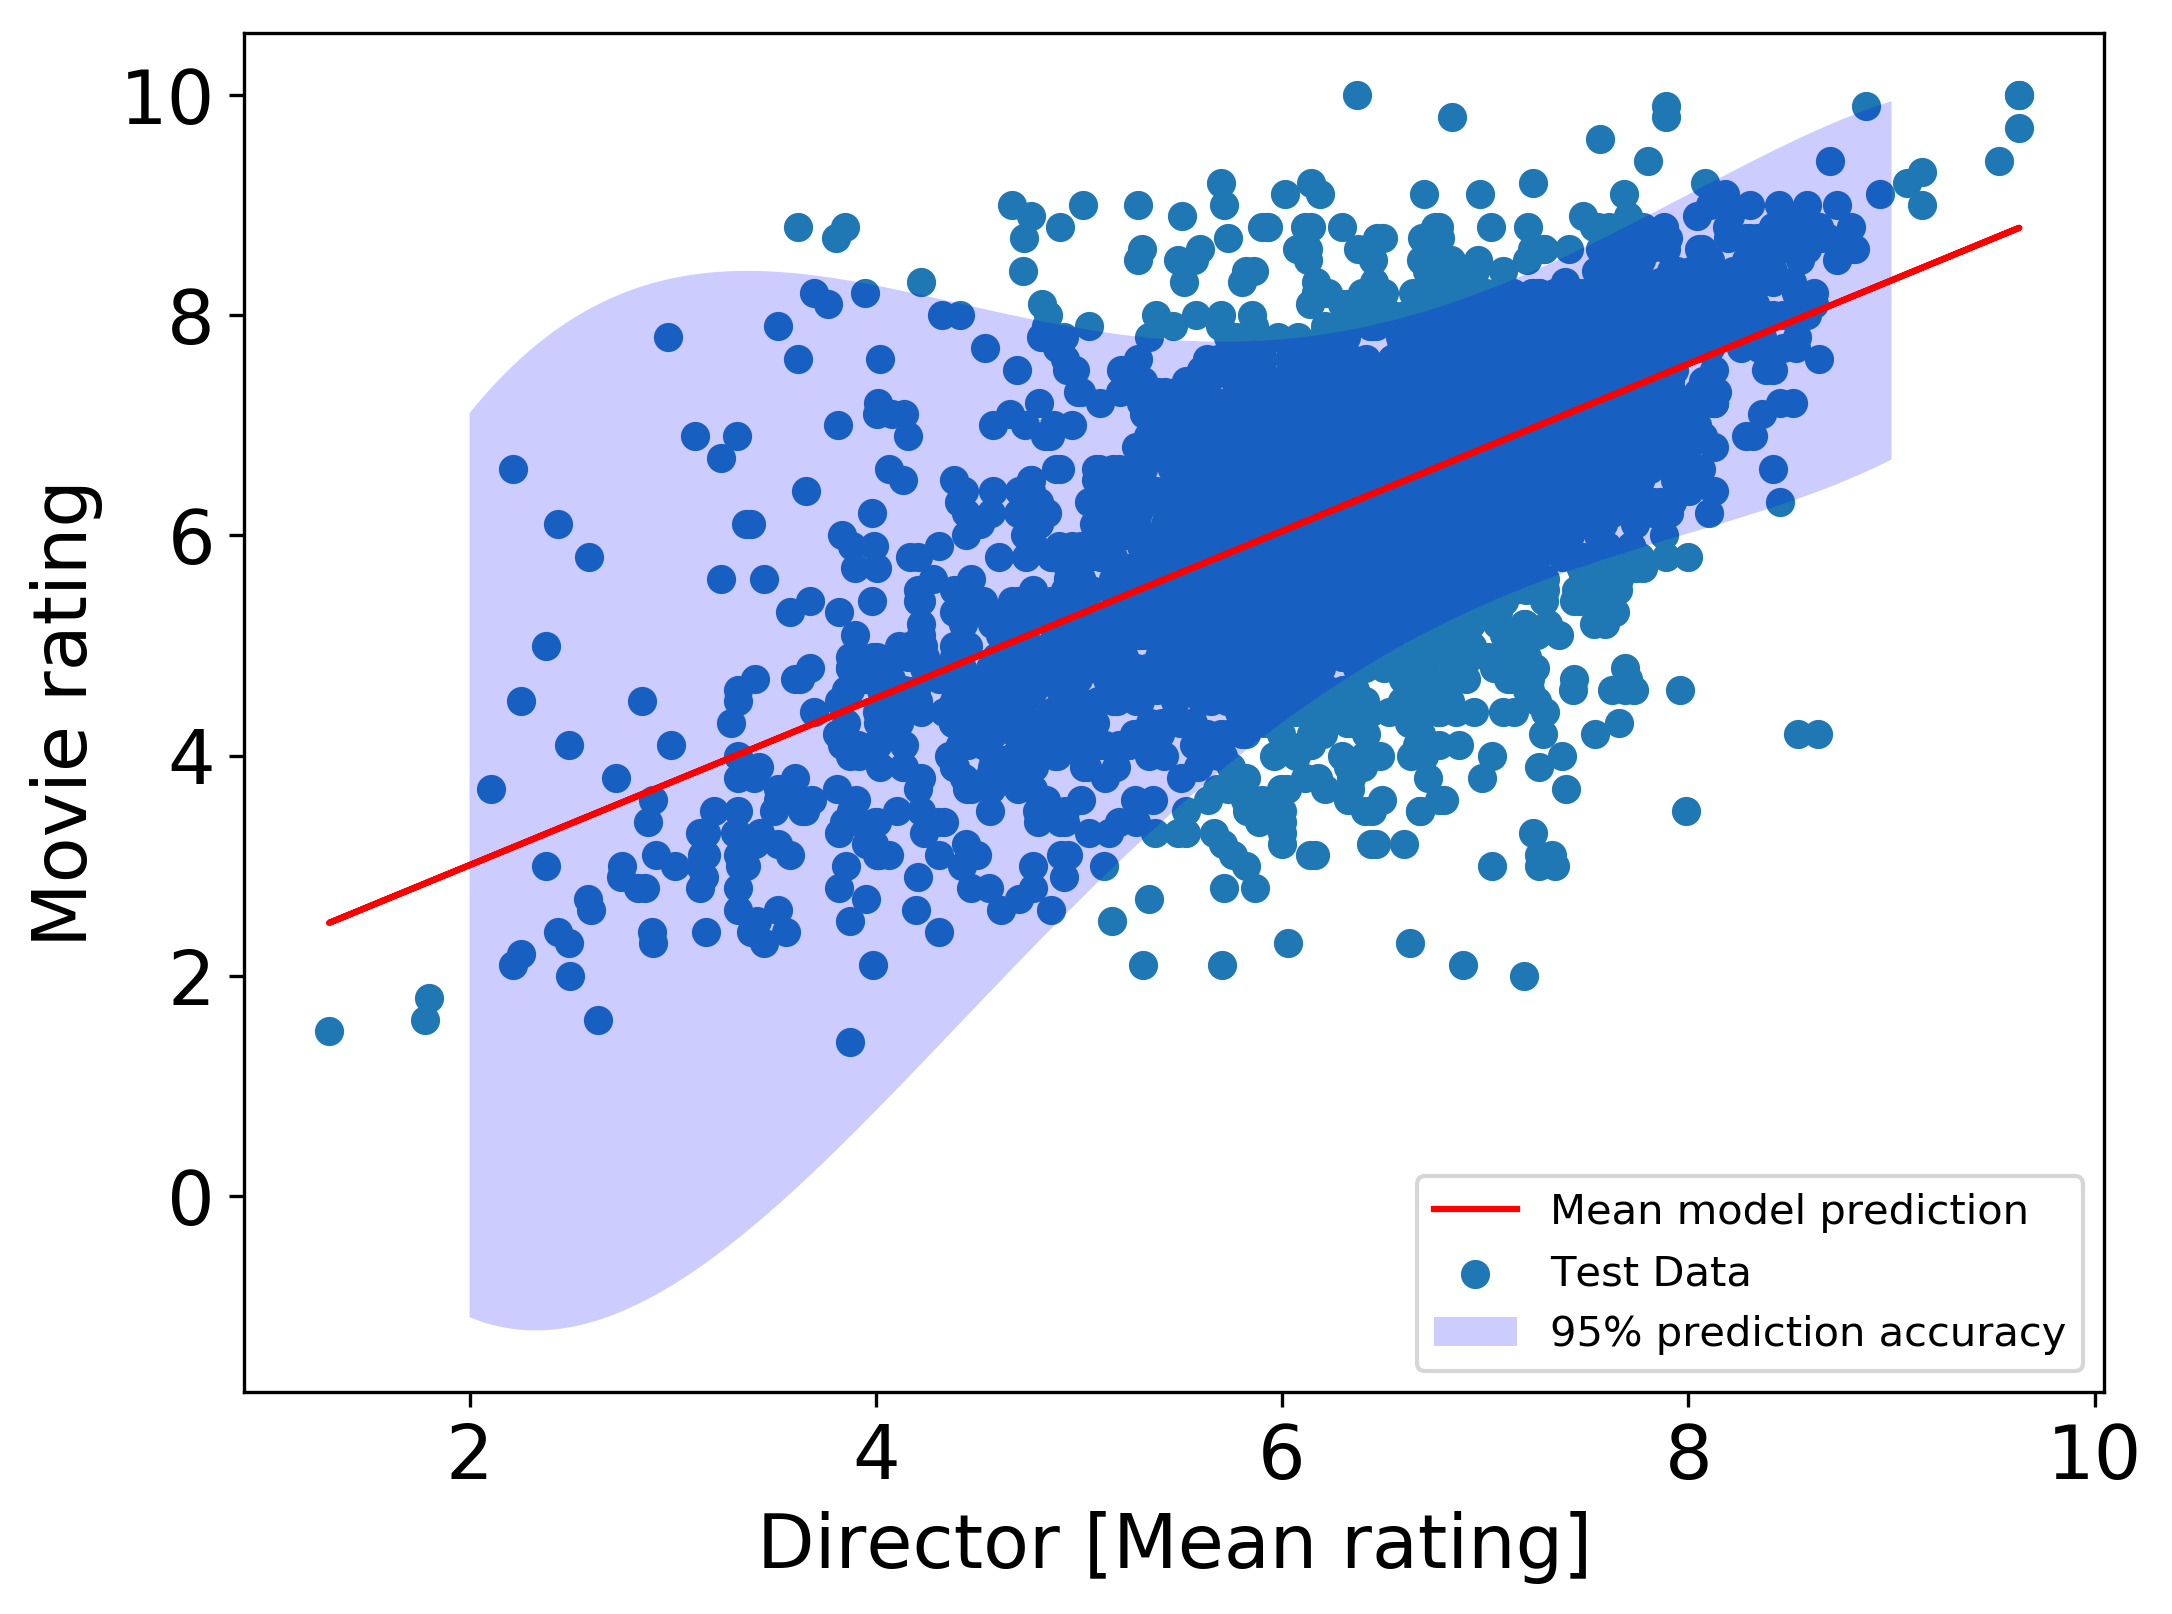

In [60]:
# Let's evaluate that model
# we compute the prediction error vector on the validation set
# and learn the function 
validation_error = (y_pred - y_test) ** 2
error_model = LinearRegression()
poly = PolynomialFeatures(4)
error_model.fit(poly.fit_transform(X_test), validation_error)

# compute the mean and standard deviation of the distribution of predictions
# assuming symmetric error
X_test_generic = np.linspace(start = 2, stop = 9, num = len(X_test)).reshape(-1,1)
y_pred_generic = model.predict(X_test_generic)
st_dev = error_model.predict(poly.fit_transform(X_test_generic))

# plot it
plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.scatter(X_test,y_test, label = 'Test Data')
plt.plot(X_test,y_pred,'r-',label = 'Mean model prediction')
upper = y_pred_generic+1.96*st_dev
lower = y_pred_generic-1.96*st_dev
plt.fill_between(X_test_generic.ravel(), lower, upper,facecolor='blue', alpha=0.2, label = '95% prediction accuracy')
plt.legend(loc=4)
plt.xlabel('Director [Mean rating]',fontsize=18)
plt.ylabel('Movie rating', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('predict_movie_rating.png',format='png')
plt.show()
#print(lower[0:10])

In [61]:
# function to give studio boss a ready answer
def pred_movie_rating(director_mean, model, error_model):
    director_mean = np.array([director_mean]).reshape(-1,1)
    pred = model.predict(director_mean)
    lower = pred - error_model.predict(poly.fit_transform(director_mean))
    upper = pred + error_model.predict(poly.fit_transform(director_mean))
    print('The movie is predicted to score:')
    print('{:.3f}'.format(pred[0]))
    print('With a 95% interval of correct prediction between:')
    print('{:.3f} and {:.3f}'.format(lower[0],upper[0]))
    return((pred[0],lower[0],upper[0]))

pred, lower, upper = pred_movie_rating(5,model,error_model)
    

The movie is predicted to score:
5.282
With a 95% interval of correct prediction between:
3.955 and 6.609


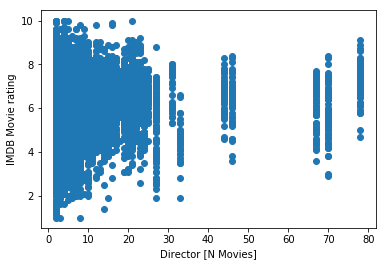

In [62]:
# we see that the movie rating that is predicted
# is a little above the mean; perhaps that could be
# due to the number of movies: the more movies
# a director has under his or her belt the better 
# the movie scores with relation to the mean (skewed distribution)
# let's evaluate a more complex movie where we add 
# the variable number of movies and the interaction
# and check if it has better predictive power
# let's plot it
X = dfdrs[['mean_rating_director','n_movies']]
y = dfdrs['imdbRating']
plt.scatter(X.n_movies,y)
plt.xlabel('Director [N Movies]')
plt.ylabel('IMDB Movie rating')
plt.show()

# if anything: there is maybe a slight increase in rating


In [63]:
# let's set-up the interaction model
res = X.mean_rating_director * X.n_movies
X['meanXn'] = res
print(X.head(10))

   mean_rating_director  n_movies      meanXn
0              4.796648         4   19.186593
1              4.796648         4   19.186593
2              4.796648         4   19.186593
3              4.796648         4   19.186593
4              6.180216        22  135.964757
5              6.180216        22  135.964757
6              6.180216        22  135.964757
7              6.180216        22  135.964757
8              6.180216        22  135.964757
9              6.180216        22  135.964757


E:\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
# split in train test and model it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = LinearRegression().fit(X_train,y_train)

# let's predict the test_data
y_pred = model.predict(X_test)

# let's look at the model
b = model.coef_
i = model.intercept_

print('The intercept and coefficients of the model formula are:')
print(np.round(i,3))
print(np.round(b,3))

# how much variance can we explain in test data?
print('\n')
print('We can explain {:.0f} percent of variance in the test data.'.format(metrics.r2_score(y_test,y_pred)*100))

# There is no increase in explained variance in the test data. So we keep the simple model.

The intercept and coefficients of the model formula are:
1.44
[ 0.772  0.005 -0.002]


We can explain 41 percent of variance in the test data.


In [80]:
# Another question:
# from the website
# 'Can we see a hype of specific genre over the past years?'
df_genres = pd.read_csv('data/Movie_Genres.csv')
df_genres = df_genres[['Genre','imdbID']]
df_genres.Genre = df_genres.Genre.str.strip()
df_genres[0:10]

,Genre,imdbID
0,Short,tt2268369
1,Drama,tt2268369
2,Short,tt1560760
3,Drama,tt1560760
4,Drama,tt0016750
5,Romance,tt0016750
6,Documentary,tt3405286
7,Short,tt3405286
8,Short,tt3816698
9,Drama,tt3816698


In [81]:
# we see that imdbIDs have multiple genres assigned
# we do an outer merge to inflate our data-frame
# three genres assigned: means three lines
# merge the genre info; for 
df_genre = df.merge(df_genres,on = 'imdbID',how='outer')

In [82]:
# how many genres are there?
len(set(df_genre.Genre))

29

In [83]:
# 29 is actually not so much for such a big data set
# let's get first per year the fraction of movies
df_genre = df_genre.dropna(axis=0,subset = ['year_final_release','Genre','imdbID'])
df_genre = df_genre[['year_final_release','Genre','imdbID']]

In [84]:
df_genre.head(10)

,year_final_release,Genre,imdbID
0,2012-01-01,Short,tt2268369
1,2012-01-01,Drama,tt2268369
2,2008-01-01,Short,tt1560760
3,2008-01-01,Drama,tt1560760
4,1926-01-01,Drama,tt0016750
5,1926-01-01,Romance,tt0016750
6,2013-01-01,Documentary,tt3405286
7,2013-01-01,Short,tt3405286
8,2014-01-01,Short,tt3816698
9,2014-01-01,Drama,tt3816698


In [85]:
# double check for multiple genres per movie in on line
comma_genres = df_genre.Genre[[str(v).find(',') != -1 for v in df_genre.Genre]]
print(comma_genres[0:10])
print('\n')

semic_genres = df_genre.Genre[[str(v).find(';') != -1 for v in df_genre.Genre]]
print(semic_genres[0:10])

Series([], Name: Genre, dtype: object)


Series([], Name: Genre, dtype: object)


In [86]:
# let's make a new df where every column is a series of frequencies
# and index are the years
# drop beyond 2018, because data there is spotty, as seen earlier
df_genre_series = pd.crosstab(df_genre.year_final_release, df_genre.Genre)
df_genre_series = df_genre_series.loc[df_genre_series.index <= datetime.datetime(year=2018,month=1,day=1),]

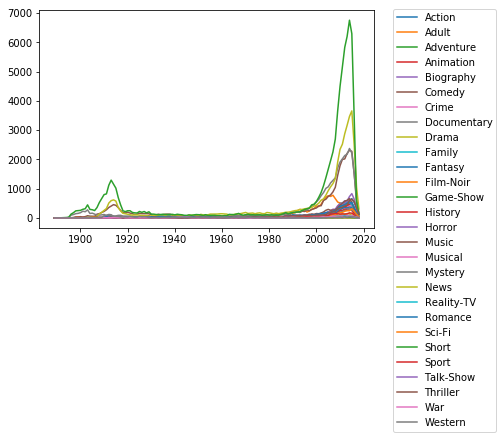

In [87]:
plt.plot(df_genre_series)
plt.legend(df_genre_series.columns,bbox_to_anchor=(1.04,1.03), loc="upper left")

In [97]:
# get the year normalization factor to get 10year intervals
td = max(df_genre.year_final_release)-min(df_genre.year_final_release)
year_norm = (td.days/365)/10

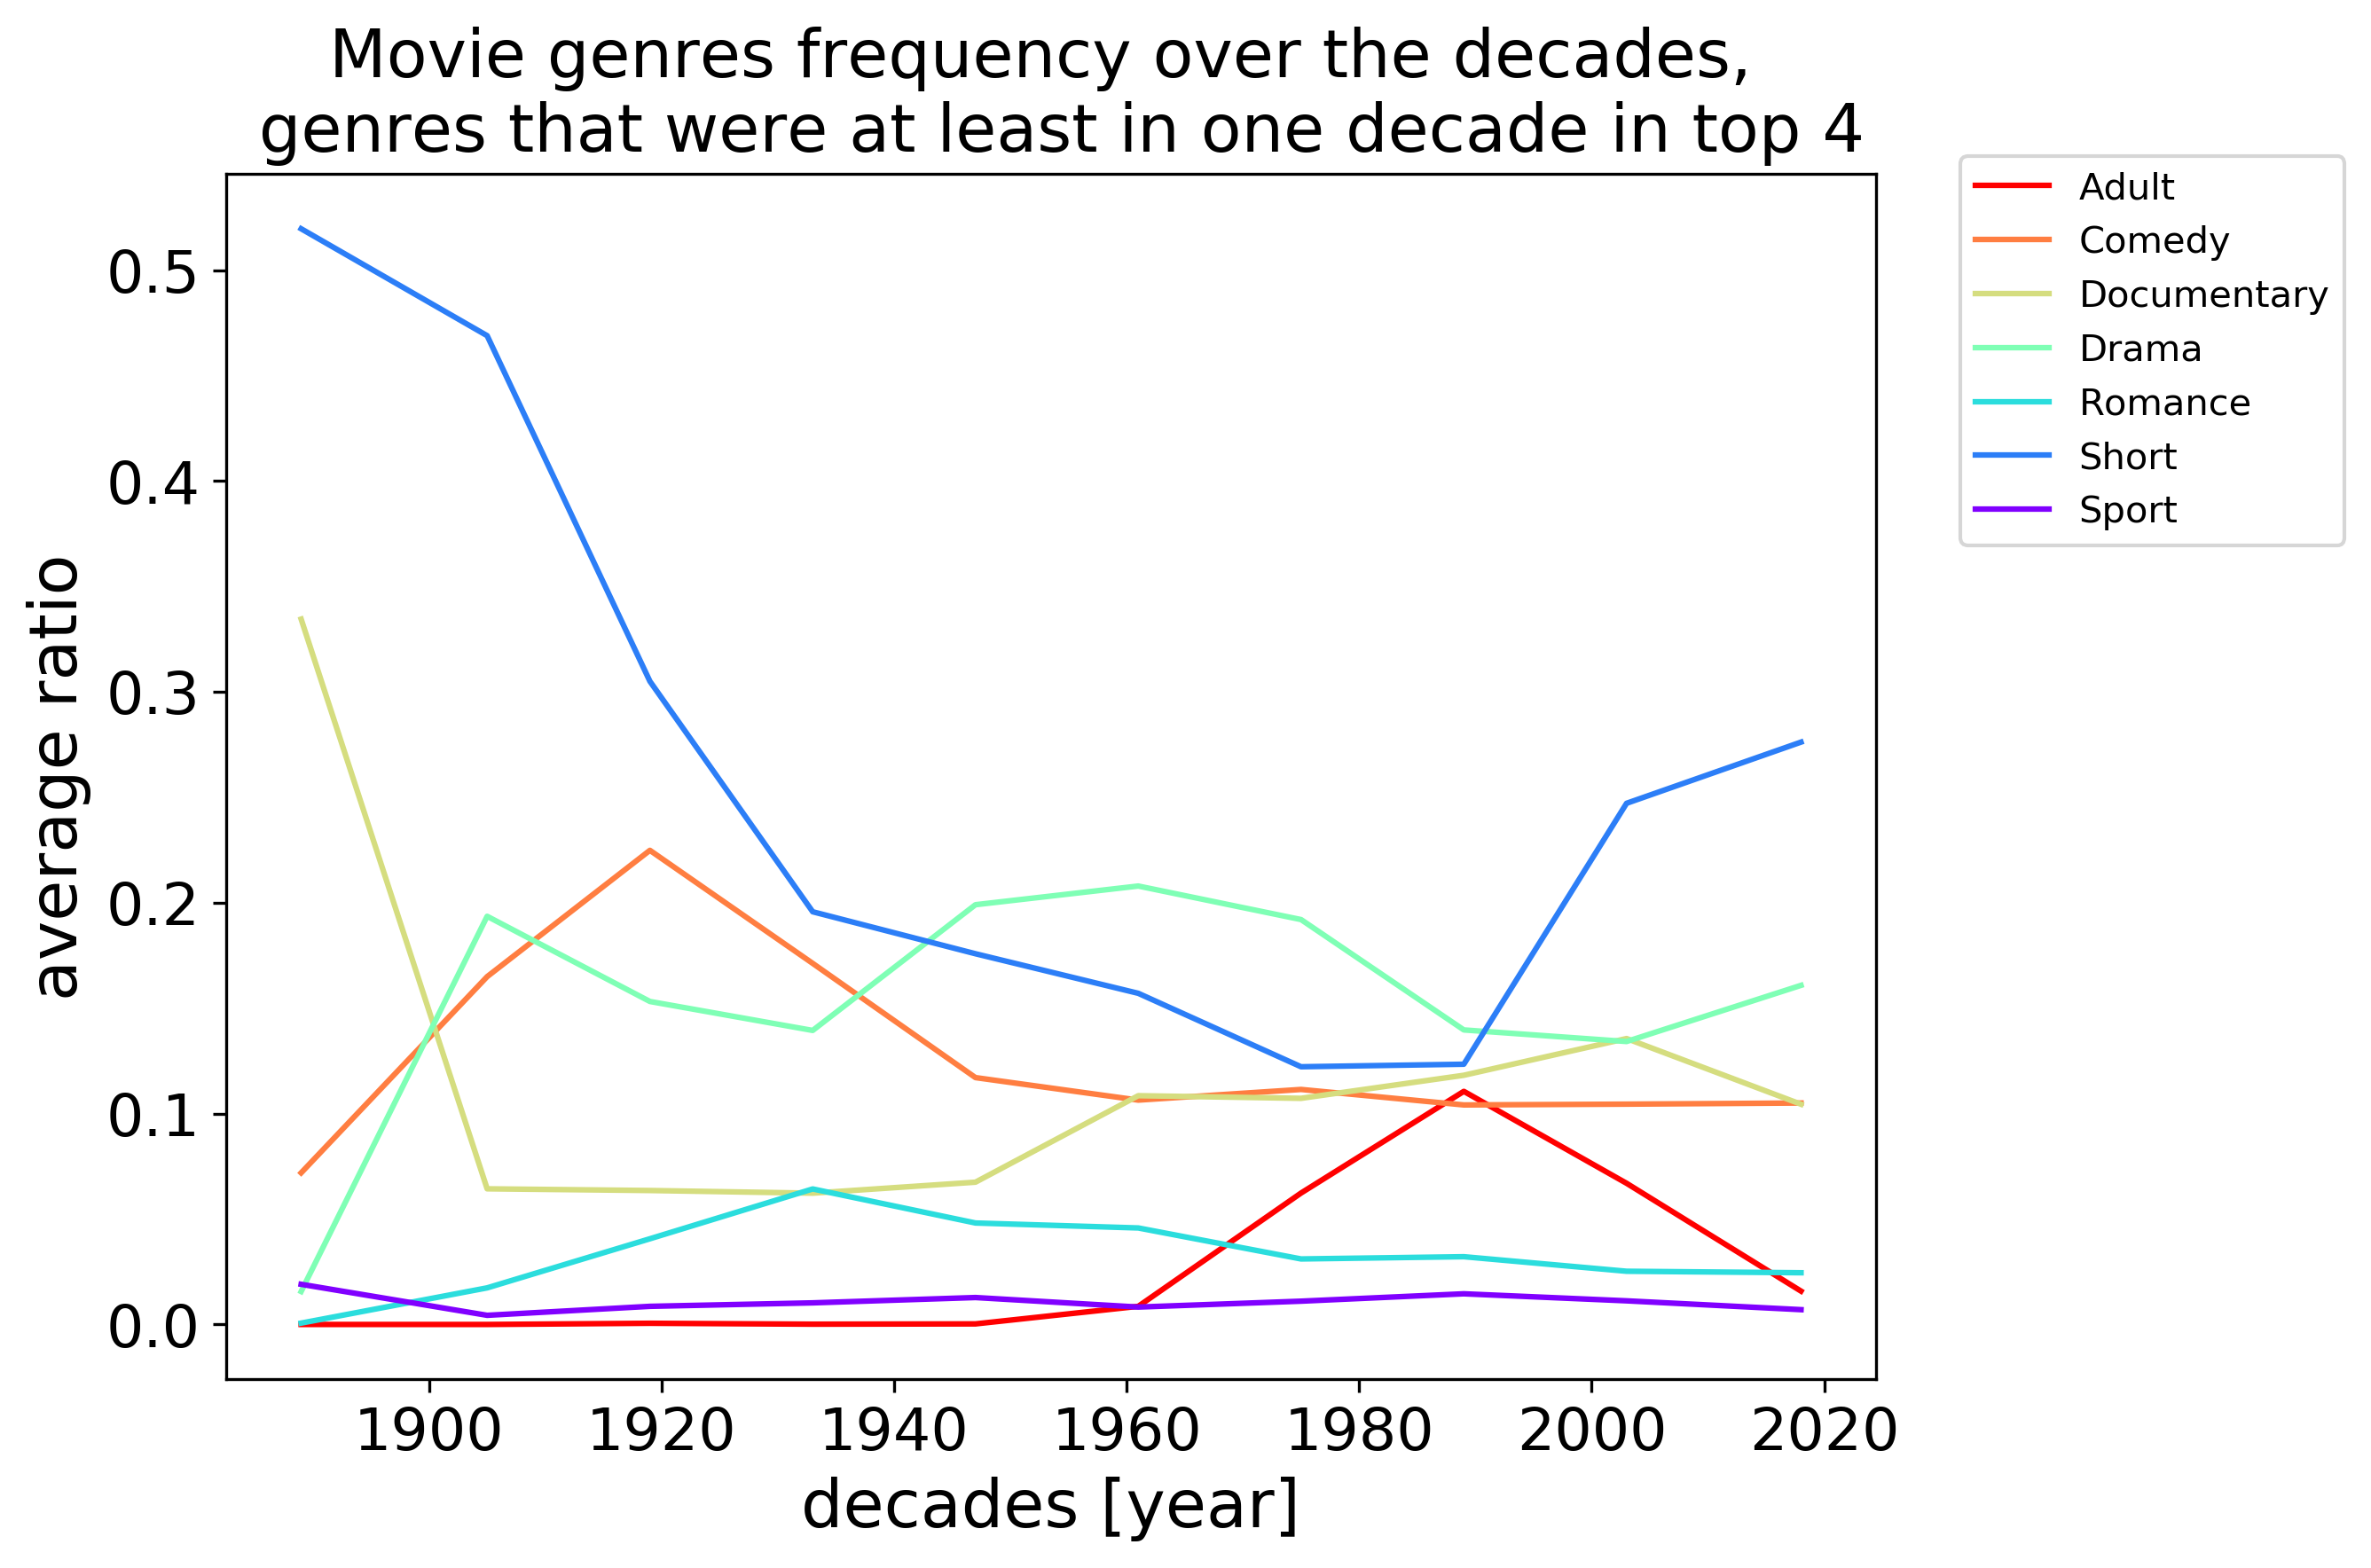

In [102]:
# the plot has too many colors/genres
# --> let's limit the plot to movies that have been
# in top 4 genres at least once over the passing decades
# and what really is important is the relative share
# in genre frequencies --> normalization
# further: a "hype" should be not just in one year but in an 
# era; let's say over ten years --> mean over ten years

# prep the data: aggregate to decade means
df_genre_series_dec = df_genre_series.groupby(np.arange(len(df_genre_series))//year_norm).mean()
df_genre_series_dec.index = df_genre_series.index[np.linspace(0,len(df_genre_series.index)-1,num=len(df_genre_series_dec)).astype(int)]

# normalize
df_genre_series_dec_norm = df_genre_series_dec.div(df_genre_series_dec.agg('sum',axis=1), axis='rows')

# get an index for the top genres for plotting
top_genres = df_genre_series_dec_norm.rank(axis = 1,ascending=False).apply(lambda x: any(x < 5),axis=0)

num_colors = df_genre_series_dec_norm.loc[:,top_genres].shape[1]

fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_prop_cycle('color',plt.cm.rainbow_r(np.linspace(0,1,num_colors)))
ax.plot(df_genre_series_dec_norm.loc[:,top_genres])
plt.legend(df_genre_series_dec_norm.loc[:,top_genres].columns,bbox_to_anchor=(1.04,1.03), loc="upper left")
plt.title('Movie genres frequency over the decades, \n genres that were at least in one decade in top 4',
         fontsize=18)
plt.xlabel('decades [year]',fontsize=18)
plt.ylabel('average ratio',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [103]:
# shorts are quite frequent, especially in the beginning of
# movie industry, when movie making was still new and expensive,
# going to the movies meant to watch a couple of short silent movies
# sometimes with live music
# shorts then had a decline but are coming back beginning in the 80s
# 90s; perhaps because now movie making has become so cheap and 
# accessible that more and more people can make short movies
# adult movies saw an increase in the 60s and until the 90s
# probably through the sexual liberation movement and the advent
# of VHS; now there is a decline, perhaps due to the internet
# where adult movie production on professional level is less in demand
# other ways of measuring the hype could be: money spent (budget) of the movie
# but we don't have the information here
# comedy hype in the 1910's 1920's could be roaring 20s and 1st WW aftermath 
# comic relief...

In [104]:
# Let's put it to a formal statistical test
# to simplify things we consider every decade as its
# independent bucket of genre frequencies
# and perform a test if genre frequencies
# are distributed, as if there is no hype
# H0: mean distirbution of genres over all decades
expected_x = df_genre_series_dec.apply(np.mean,axis=0)

def chi_top_genre(x,expected_x,against):
    """Assumes x is list of count numbers.
    Tests whether max(x) is larger than expected under H0.
    H0 is the expected x which is equal count for all
    elements in x. max(x) = (sum(x)/len(x))*(len(x)-1)"""
    
    x_max = max(x)
    x_max_expected = expected_x[expected_x.idxmax()]
    
    if against == 'all':
        # observed
        sum_others = sum(x.drop(index=x.idxmax()))
        
        # expected
        all_others_freq_H0 = sum(expected_x.drop(index=x.idxmax()))
        
    elif against == 'top_two':
        # observed
        x_others = x.drop(index=x.idxmax())
        sum_others = max(x_others) # next max
        
        # expected
        expected_drop_max = expected_x.drop(index=x.idxmax())
        all_others_freq_H0 = max(expected_drop_max) # next max in expected_x
    else:
        raise ValueError('Unknown input for "against" argument.')
        
    # test
    chi2_res = sp.stats.chisquare(f_obs=[x_max,sum_others],
                              f_exp=[x_max_expected,all_others_freq_H0])
        
    return(chi2_res)
  

print(df_genre_series_dec.apply(chi_top_genre,axis=1,args=(expected_x,'top_two')))
print('\n')
print(df_genre_series_dec.apply(chi_top_genre,axis=1,args=(expected_x,'all')))
print('\n')
print('Testing the top genre against all others or against the second-top genre is sig. in all decades.')
print('This is to be expected in such a big data set where even small deviations can be stat. significant.')
print('It is up to interpretation if this is practically sig.')

year_final_release
1889-01-01       (761.12392735648, 1.5299695665779357e-167)
1905-01-01        (69.0749958047311, 9.478953026382206e-17)
1919-01-01     (680.8336948627251, 4.4017522388801317e-150)
1933-01-01      (879.6275553208682, 2.633914151654773e-193)
1947-01-01    (1221.6083703534537, 1.2280954720578955e-267)
1961-01-01     (1149.0100478317481, 7.362736905520422e-252)
1975-01-01     (1122.3404812572142, 4.606305503272325e-246)
1989-01-01     (779.0615694222035, 1.9254318807634785e-171)
2003-01-01                        (3000.2558039806613, 0.0)
2018-01-01                        (22454.265956342184, 0.0)
dtype: object


year_final_release
1889-01-01                        (2425.158034913591, 0.0)
1905-01-01    (913.3590629193659, 1.2238961880989807e-200)
1919-01-01                       (1899.7557001989496, 0.0)
1933-01-01                       (1999.5779442970315, 0.0)
1947-01-01                       (2393.1702207018216, 0.0)
1961-01-01                       (2177.817317982644

In [105]:
# second to last own task (predictive modeling):
# build a movie recommender based on content
# we build a function where we put in 1 previously watched movie
# and get out the 10 next most similar ones as a recommendation

In [106]:
# drop na
df_overview = df.dropna(subset=['Plot'],axis=0)
df_overview.reset_index(inplace=True)
print(df_overview.Plot[0:50])

0     Rachel constantly hears her baby cry from the ...
1     The struggle against unfortunate circumstances...
2     A Gift introduces Samuel Green, Washington Sta...
3     When heavily armed campus police broke into th...
4     Exploring lives affected after the 23 years Wa...
5     A poor man does his best to raise his three ch...
6     An overview of the production design for the f...
7     SUGAR PINE FALLS is about growing up fast. Mon...
8     Steve, a recent widower, is trying stay strong...
9     The Celebrity Experience is an interactive tal...
10    Tom and Brenda have the perfect life but when ...
11    Insurance sales Chen Wen is single for long, a...
12    Billy Cassidy visits St. John's Hospital in th...
13    It's a high-flying adventure when Louie, a mut...
14    What would happen if you met a carbon copy of ...
15    The son of a deceased Coast Guard hero is rais...
16    A girl saves a wounded soldier left by a rival...
17    High Stakes is a 1931 American Pre-Code co

In [107]:
# get a sample for memory reasons
df_overview_s = df_overview.sample(n = 4000, random_state=50)
df_overview_s.reset_index(inplace=True)

In [108]:
# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english',max_features=3000)

# Replace NaN with an empty string
#df2['overview'] = df2['overview'].fillna('')

# Construct the required TF-IDF matrix by fitting the word embedding to vectors
# and transforming the data
tfidf.fit(df_overview_s.Plot)
tfidf_matrix = tfidf.transform(df_overview_s.Plot)

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(4000, 3000)

In [109]:
# similarity score: cosine similarity
# is independent of magnitude
# just measures if vectors point into same direction
# similarity = cos(theta) = A*B/(norm(A)*norm(B))
# ... = sum_i(Ai*Bi)/(sqrt(sum_i(Ai_squared))*sqrt(sum_i(Bi_squared)))
# since we used TF*IDF the vectors are already normed
# so we can use just use the denominator, i.e. the dot product

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(4000, 4000)

In [110]:
# we need a mechanism to identify the index of a movie
# in our DataFrame, given its imdbID.
indices = pd.Series(df_overview_s.index, index=df_overview_s['Title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    """function to return 10 most similar movies"""
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #print(sim_scores)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_overview_s['Title'].iloc[movie_indices]





In [111]:
cur_title = df_overview_s['Title'].iloc[200]
print('Watched movie:')
print(cur_title)
print(df_overview_s.Plot.loc[df_overview_s.Title == cur_title])

recom = get_recommendations(cur_title,cosine_sim=cosine_sim)

print('\n')
print('Recommended movies:')
for t in recom:
    print(df_overview_s.Plot.loc[df_overview_s.Title == t])
    print('\n')

Watched movie:
Killing My Girl
200    A young South Asian woman lives away from home...
Name: Plot, dtype: object


Recommended movies:
1205    A woman and a man are travelling back from an ...
Name: Plot, dtype: object


766    Antara Shelar lives an upper middle-class life...
Name: Plot, dtype: object


3467    Following her husband's death, a young woman g...
Name: Plot, dtype: object


2268    After running away fails, a terrified woman (J...
Name: Plot, dtype: object


2846    Five shapely cuties are captured by home intru...
Name: Plot, dtype: object


802    Young Chicagoans struggle with relationships a...
Name: Plot, dtype: object


1126    A mid-twenties girl is pregnant and doesn't wa...
Name: Plot, dtype: object


1551    Seventy-year-old teenagers running away from h...
Name: Plot, dtype: object


940    A young woman returns home after attempting su...
Name: Plot, dtype: object


935    The inspiring, slightly fictionalized true sto...
Name: Plot, dtype: object




In [113]:
# last question: I heard that Germany and France
# were quite the big movie producers in the advent of film
# in the early 20th century up to the 1920s and 1930s
# let's see how that looks then and now:

# get a subset of the data and drop the nan
df_c = df[['year_final_release','Country']]
df_c = df_c.dropna(axis=0)


def perc_countries(df_c,condition):
    # just get the movies before 1940; multinational movies get all the nations counted
    c_then = df_c.Country.loc[condition].str.split(',')

    # concat the movies and do white-stripping
    c_then = pd.Series(np.hstack(c_then).ravel())
    c_then = c_then.str.strip().value_counts()
    c_then = c_then/c_then.sum()
    c_then = pd.Series(c_then.iloc[np.array(range(0,6))]).append(pd.Series(c_then.iloc[6:].sum(),index=['Other']))

    return(c_then)

c_then = perc_countries(df_c,condition=df_c.year_final_release<pd.Timestamp(year=1940,month=1,day=1))
c_now = perc_countries(df_c,condition=df_c.year_final_release>pd.Timestamp(year=1970,month=1,day=1))



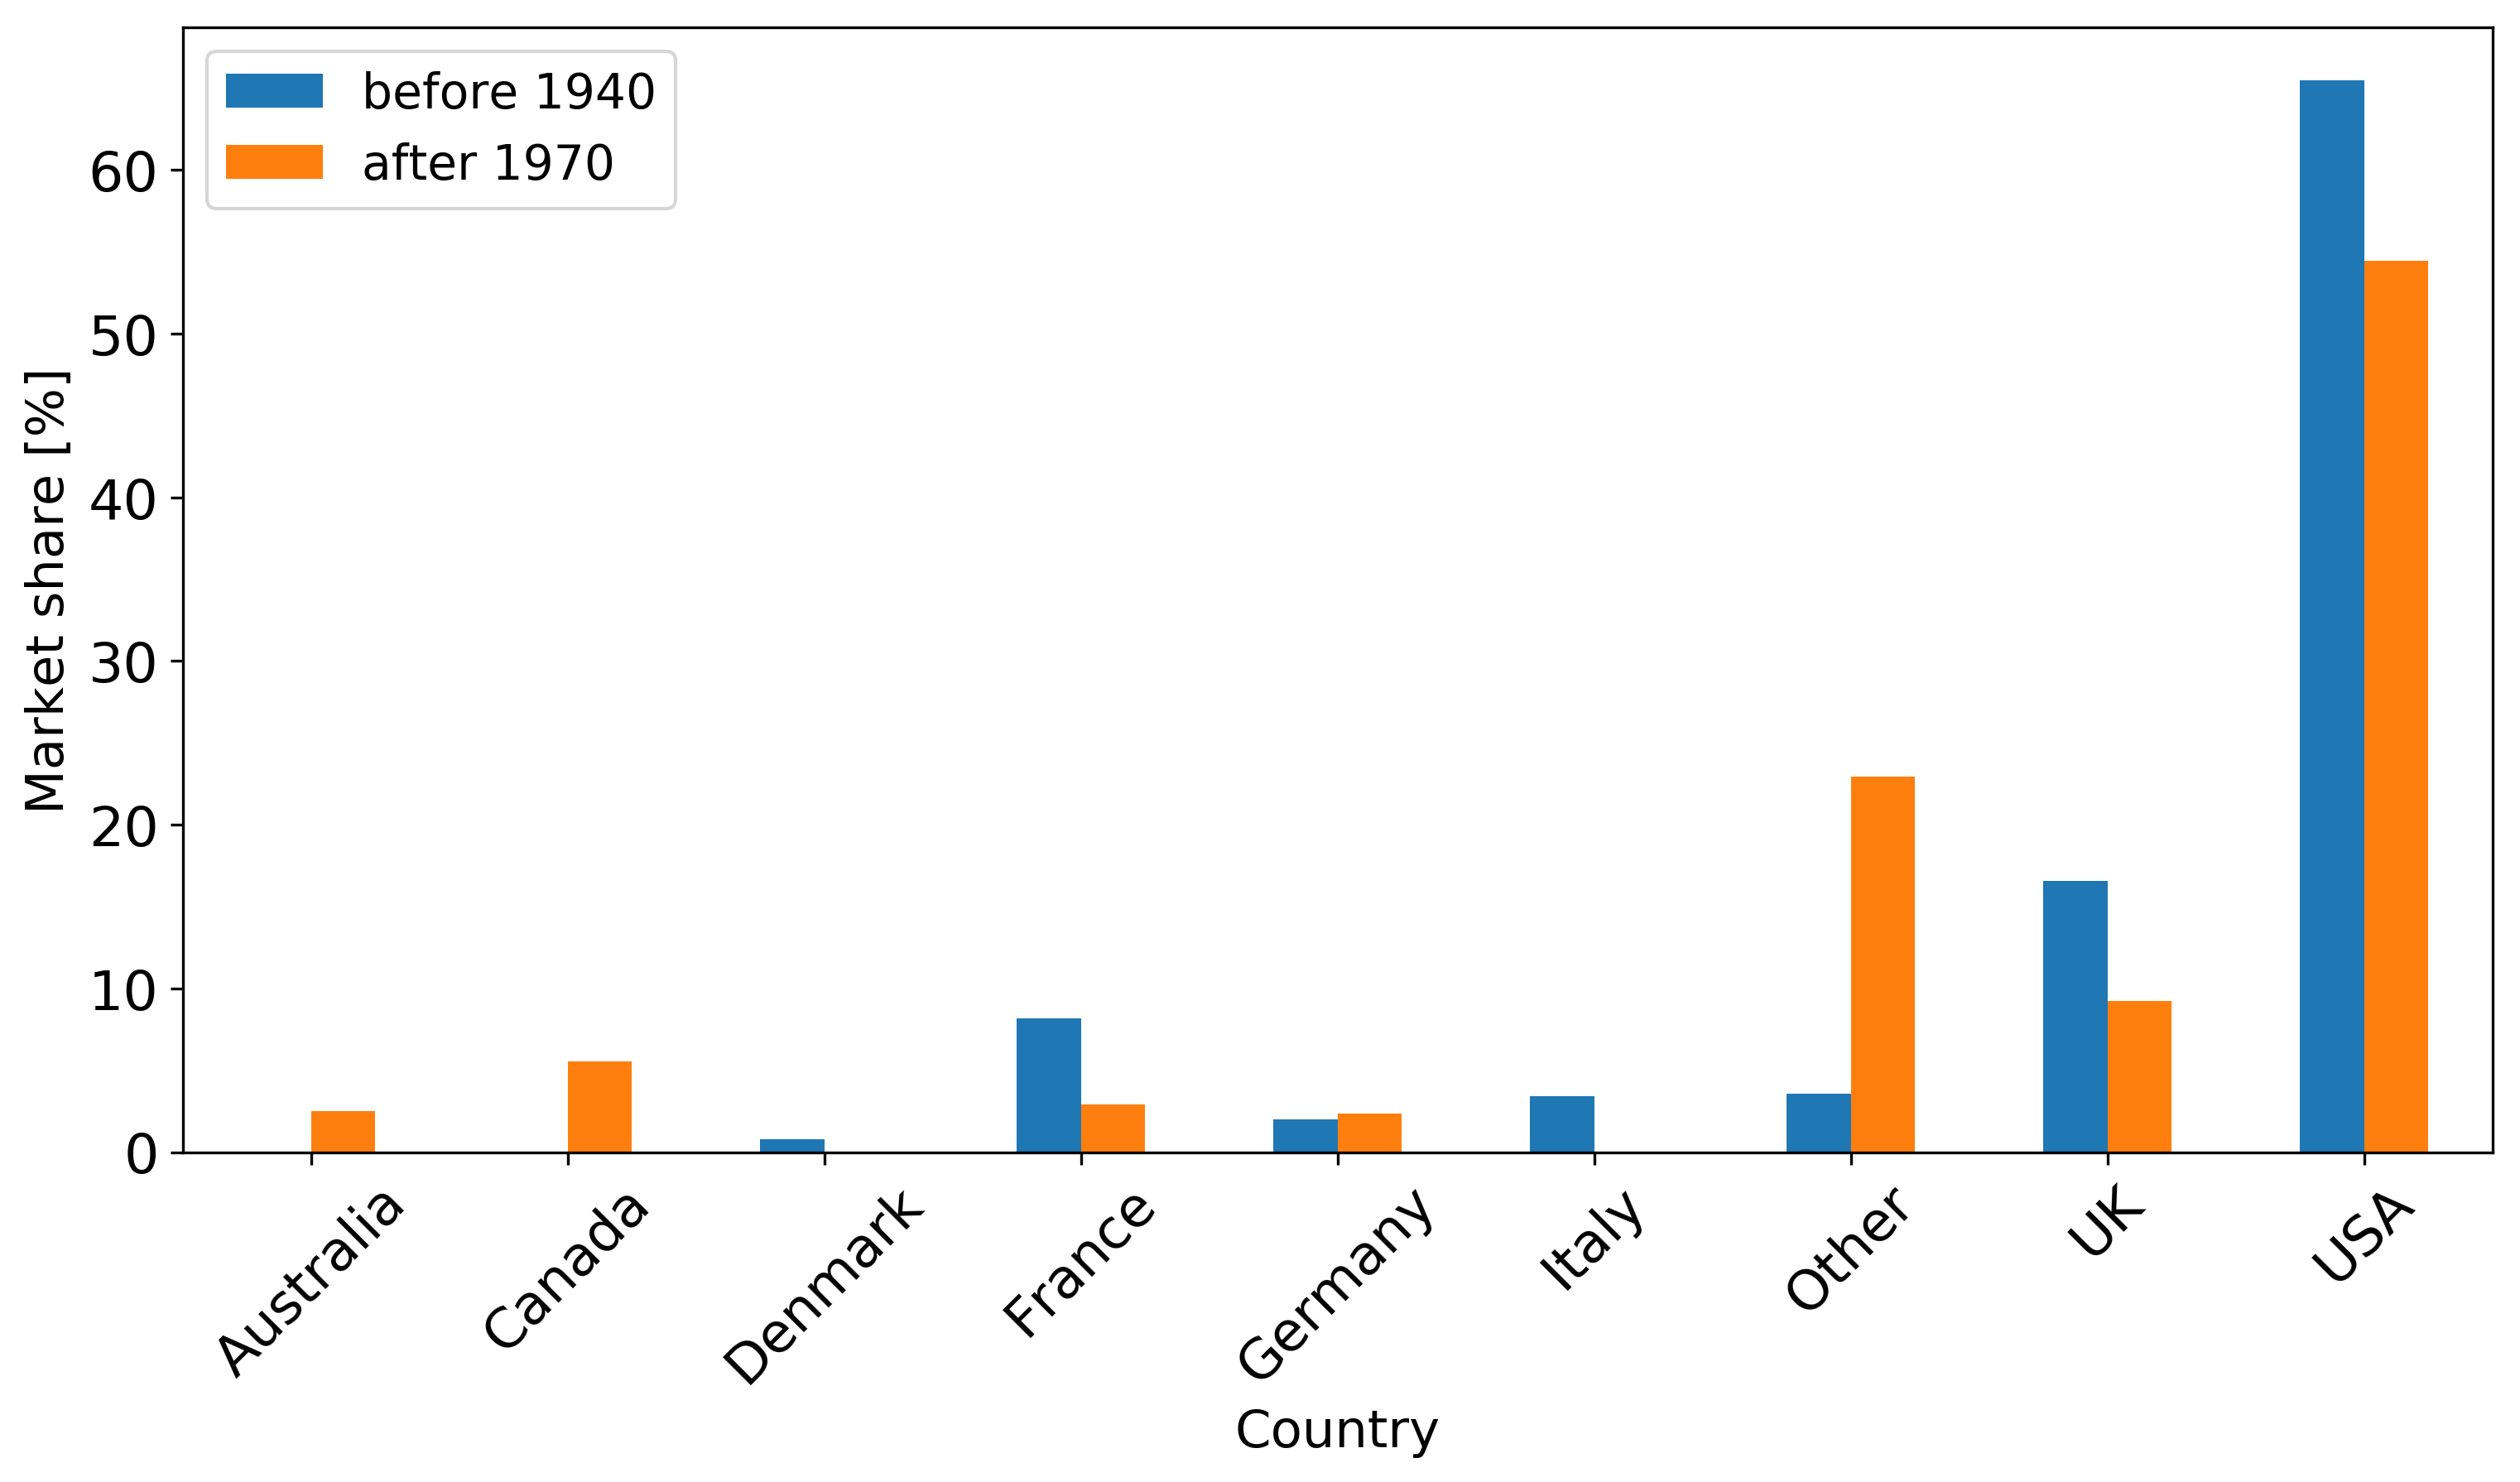

In [127]:
# c_then and c_now need to get the all common categories
c_bar_df = pd.DataFrame({'c_then': c_then})
c_bar_df = c_bar_df.merge(pd.DataFrame(c_now),how='outer',left_index=True,right_index=True)
c_bar_df.columns=['before 1940','after 1970']
c_bar_df = c_bar_df.fillna(0)
c_bar_df = c_bar_df*100

fig = plt.figure(num=None, figsize=(12, 6), dpi=300, facecolor='w', edgecolor='k')
plt.xlabel('Country',fontsize=15)
plt.ylabel('Market share [%]',fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = fig.gca()

c_bar_df.plot.bar(rot=45,ax=ax)
ax.legend(fontsize=14)
#ax.text(style='italic')


plt.show()



In [ ]:
# We see that that the US actually sees a drop in market share
# There are movies made worldwide ('other')
# Germany's market share is stable, however, France and Italy saw a severe drop
# Australia and Canada have gained traction 
# EU ???

# another question: are ratings for older movies more generous?